'The most difficult thing in life is to know yourself'

This quote belongs to Thales of Miletus. Thales was a Greek/Phonecian philosopher, mathematician and astronomer, which is recognised as the first individual in Western civilisation known to have entertained and engaged in scientific thought (source: https://en.wikipedia.org/wiki/Thales)

We won't say that knowing your data is the most difficult thing in data science, but it is time-consuming. Therefore, it's easy to overlook this initial step and jump too soon into the water.

So we tried to learn how to swim before jumping into the water. 

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import warnings
from scipy.stats import norm, skew #for some statistics

warnings.filterwarnings('ignore')

%matplotlib inline

In [79]:
df = pd.read_csv("houses_to_rent_combined.csv")

What we will be doing in EDA are as follows:-
1. Understand the problem. We'll look at each variable and do a philosophical analysis about their meaning and      importance for this problem.
2. Univariable study. We'll just focus on the dependent variable ('rent') and try to know a little bit more about it.
3. Multivariate study. We'll try to understand how the dependent variable and independent variables relate.

Our statistical models makes good assumptions about:-
1. Linearity: assumes that the relationship between predictors and target variable is linear
2. No noise: eg. that there are no outliers in the data
3. No collinearity: if you have highly correlated predictors, it’s most likely your model will overfit
4. Normal distribution: more reliable predictions are made if the predictors and the target variable are normally distributed
5. Scale: it’s a distance-based algorithm, so preditors should be scaled — like with standard scaler

In [80]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,Hassoc_tax,rent,prop_tax,fire_insur
0,1,240,3,3,4,0,acept,furnished,0,8000,1000,121
1,0,64,2,1,1,10,acept,not furnished,540,820,122,11
2,1,443,5,5,4,3,acept,furnished,4172,7000,1417,89
3,1,73,2,2,1,12,acept,not furnished,700,1250,150,16
4,1,19,1,1,0,0,not acept,not furnished,0,1200,41,16


In [101]:
df.dtypes

city               object
area              float64
rooms             float64
bathroom          float64
parking spaces    float64
floor             float64
animal             object
furniture          object
Hassoc_tax        float64
rent              float64
prop_tax          float64
fire_insur        float64
dtype: object

In [81]:
#columns 'Hassoc_tax' and 'prop_tax' has few string values, let's first remove them
df.loc[df['Hassoc_tax'] == 'Sem info','Hassoc_tax'] = 0
df.loc[df['Hassoc_tax'] == 'Incluso','Hassoc_tax'] = 0
df['Hassoc_tax'] = df['Hassoc_tax'].astype(float)
df.loc[df['prop_tax'] == 'Incluso','prop_tax'] = 0
df['prop_tax'] = df['prop_tax'].astype(float)

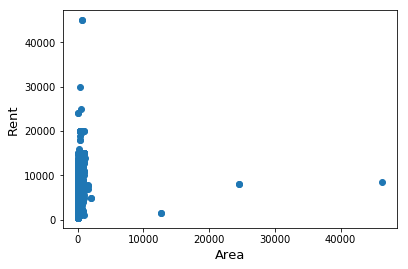

In [82]:
fig, ax = plt.subplots()
ax.scatter(x = df['area'], y = df['rent'])
plt.ylabel('Rent', fontsize=13)
plt.xlabel('Area', fontsize=13)
plt.show()

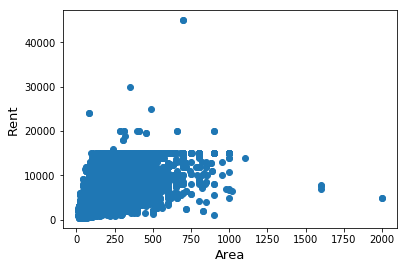

In [83]:
#Deleting outliers
df = df.drop(df[(df['area']>10000) & (df['rent']<22000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(x = df['area'], y = df['rent'])
plt.ylabel('Rent', fontsize=13)
plt.xlabel('Area', fontsize=13)
plt.show()

NOTE

Outliers removal is not always safe. We decided to delete these three as they are very huge and really bad ( extremely large areas for very low prices).

There are probably others outliers in the training data. However, removing all them may affect badly our models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them. 


 mu = 4151.97 and sigma = 3505.43



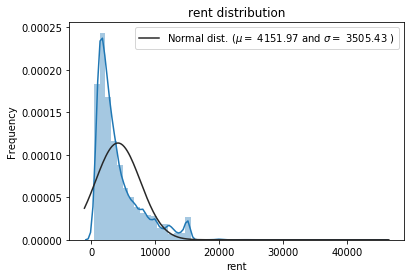

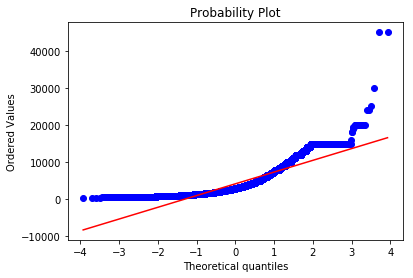

In [84]:
sns.distplot(df['rent'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['rent'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('rent distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['rent'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

Ok, 'rent' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

But everything's not lost. A simple data transformation can solve the problem. This is one of the awesome things you can learn in statistical books: in case of positive skewness, box cox transformations usually works well. When we discovered this, we felt like an Hogwarts' student discovering a new cool spell.

To learn more about skewness: https://www.analyticsvidhya.com/blog/2020/07/what-is-skewness-statistics/

Box Cox Transformations: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html


 mu = 8.02 and sigma = 0.79



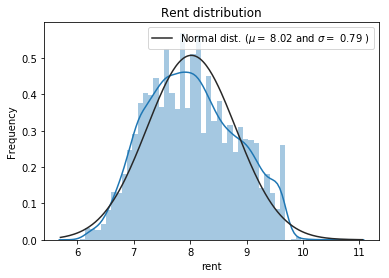

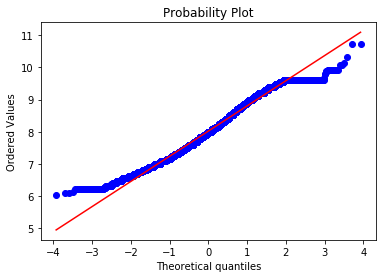

In [85]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["rent"] = np.log1p(df["rent"])
df['area'] = np.log1p(df['area'])

#Check the new distribution 
sns.distplot(df['rent'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['rent'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rent distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['rent'], plot=plt)
plt.show()

The skew seems now corrected and the data appears more normally distributed.

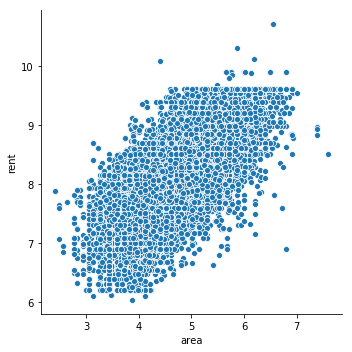

In [86]:
#plot after reducing skewness from the columns 'area' and 'rent'
sns.relplot(x = 'area', y='rent', data = df)

In [87]:
df.isnull().sum()

city              0
area              0
rooms             0
bathroom          0
parking spaces    0
floor             0
animal            0
furniture         0
Hassoc_tax        0
rent              0
prop_tax          0
fire_insur        0
dtype: int64

DATA CORRELATION

In [88]:
numeric_feats = df.dtypes[df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Hassoc_tax,104.052764
prop_tax,71.687631
floor,8.411508
fire_insur,1.842657
parking spaces,1.444766
bathroom,1.127370
rooms,0.630583
area,0.259375
rent,0.161424


In [89]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 9 skewed numerical features to Box Cox transform


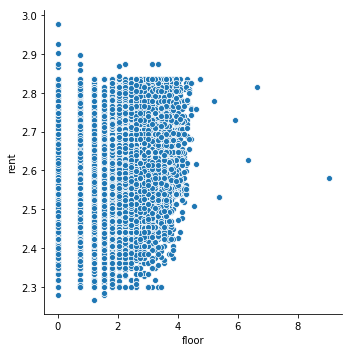

In [90]:
#plot after reducing skewness from the columns 'area' and 'rent'
sns.relplot(x = 'floor', y='rent', data = df)

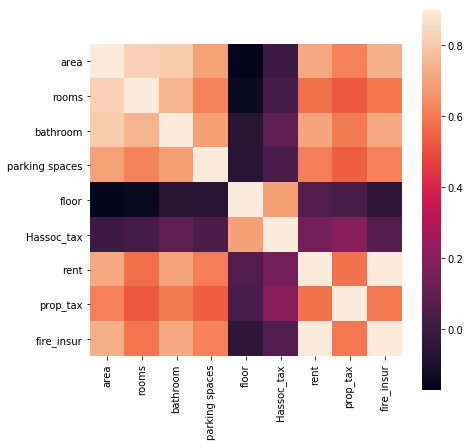

In [91]:
#Correlation map to see how features are correlated with rent
corrmat = df.corr()
plt.subplots(figsize=(7,7))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [19]:
#highly correlated feature
cor_feat = ['area', 'rooms', 'bathroom', 'parking spaces', 'fire_insure', 'prop_tax']

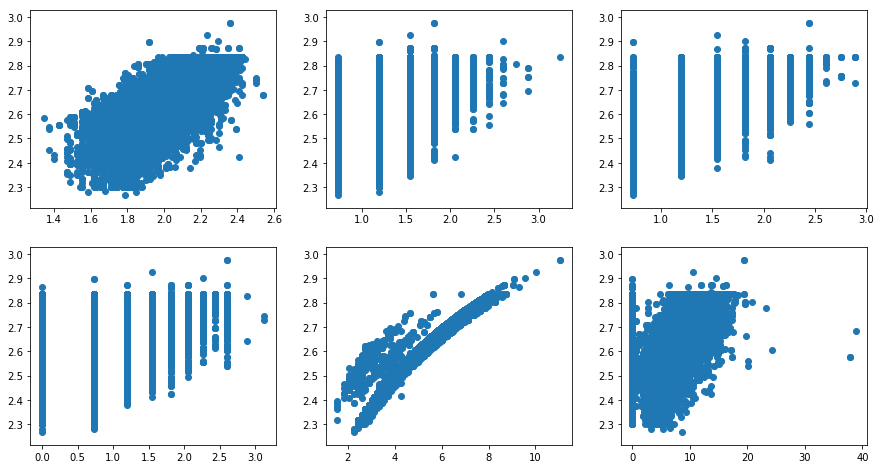

In [97]:
plt.rcParams["figure.figsize"] = (15,8)
fig, ax = plt.subplots(2,3)
ax[0,0].scatter(df['area'], df['rent'])
ax[0,1].scatter(df['rooms'], df['rent'])
ax[0,2].scatter(df['bathroom'], df['rent'])
ax[1,0].scatter(df['parking spaces'], df['rent'])
ax[1,1].scatter(df['fire_insur'], df['rent'])
ax[1,2].scatter(df['prop_tax'], df['rent'])

In [98]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,Hassoc_tax,rent,prop_tax,fire_insur
0,1,2.157896,1.540963,1.540963,1.820334,0.000000,acept,furnished,0.000000,2.748458,12.125370,7.037818
1,0,1.864091,1.194318,0.730463,0.730463,2.885846,acept,not furnished,10.468500,2.390061,7.054610,3.011340
2,1,2.277897,2.055642,2.055642,1.820334,1.540963,acept,furnished,16.612959,2.729471,13.133105,6.426513
3,1,1.895823,1.194318,1.194318,0.730463,3.128239,acept,not furnished,11.147538,2.462601,7.483296,3.530419
4,1,1.539649,0.730463,0.730463,0.000000,0.000000,not acept,not furnished,0.000000,2.455717,5.012077,3.530419
